Test Q1
contact 2
yahoo 3
http 1
login.yahoo.com 1
select 1
forget 1
password 2
fail 1
reset 1
department 2
408-349-1572 1
promise 1
phone 1
fix 1
know 1
go 1
next 1
corporate 2
email 2
come 1
free 1
mail 1
system 1
address 2
space 1
webmaster@yahoo.com 1

Test Q2
[158] [1.]
why the sky is blue?
158    why is the sky blue?
Name: question, dtype: object
[71] [0.24279559]
why the moon show the same face?
71    when is the next full moon?
Name: question, dtype: object

Test Q3.1

Test Q3.2


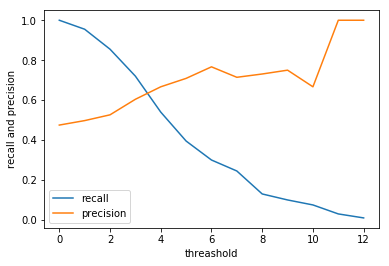

In [68]:
import pandas as pd
import numpy as np
import nltk
from scipy.spatial import distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
def tokenize(text):
    token_count = None
    text = text.lower()
    pattern = r'\w[\w\-_\.@]*\w'
    tokens=nltk.regexp_tokenize(text, pattern)
    temp = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for x in tokens:
        temp.append(wordnet_lemmatizer.lemmatize(x,wordnet.VERB))
    stop_words = stopwords.words('english')
    word_dist=nltk.FreqDist(temp)
    token_count={word: word_dist[word] \
                     for word in word_dist \
                     if word not in stop_words} #and
                        #word not in string.punctuation}
    return token_count

def find_similar_doc(doc_id, docs):
    best_matching_doc_id = None
    similarity = None
    docs_tokens={idx:tokenize(doc) \
             for idx,doc in enumerate(docs)}
    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index" )
    dtm=dtm.fillna(0)
    tf=dtm.values
    doc_len=tf.sum(axis=1)
    tf=np.divide(tf.T, doc_len).T
    df=np.where(tf>0,1,0)
    smoothed_idf=np.log(np.divide(len(docs)+1, np.sum(df, axis=0)+1))+1    
    smoothed_tf_idf=tf*smoothed_idf
    similarity = 1-distance.squareform(distance.pdist(smoothed_tf_idf, 'cosine'))
    best_matching_doc_id = np.argsort(similarity)[:,::-1][doc_id,1:2]
    similarity = similarity[doc_id][best_matching_doc_id]
    return best_matching_doc_id, similarity

def match_question_answer(questions, answers):
    result = []
    doc_tokens = {idx:tokenize(doc) \
             for idx,doc in enumerate(questions + answers)}
    doc_dtm = pd.DataFrame.from_dict(doc_tokens, orient="index" )
    doc_dtm = doc_dtm.fillna(0)
    doc_tf = doc_dtm.values
    doc_doc_len = doc_tf.sum(axis=1)
    doc_tf = np.divide(doc_tf.T, doc_doc_len).T
    doc_df = np.where(doc_tf>0,1,0)
    doc_smoothed_idf = np.log(np.divide(len(questions + answers)+1, np.sum(doc_df, axis=0)+1))+1    
    doc_smoothed_tf_idf = doc_tf * doc_smoothed_idf
    que_smoothed_tf_idf = doc_smoothed_tf_idf[:len(questions)]
    ans_smoothed_tf_idf = doc_smoothed_tf_idf[len(questions):]
    similarity = 1 - distance.cdist(que_smoothed_tf_idf, ans_smoothed_tf_idf, 'cosine')
    best_matching_doc_id = np.argsort(similarity)[:,::-1][:,0:1]
    for idx, x in enumerate(best_matching_doc_id):
        result.append((idx,x[0],similarity[idx][x[0]]))
    
    return result

def evaluate(result):
    data = []
    min_sim = 0
    while min_sim <= 0.6:
        matching_pairs = []
        for x in result:
            if (x[2] >= min_sim):
                matching_pairs.append(x)
        recall = len(matching_pairs) / len(result)
        temp = 0
        for x in matching_pairs:
            if x[0] == x[1]:
                temp += 1
        precision = temp / len(matching_pairs)
        data.append((recall, precision))
        min_sim += 0.05
    df = pd.DataFrame.from_records(data, columns = ['recall', 'precision'])
    df.plot(kind='line')
    
    plt.xlabel('threashold')
    plt.ylabel('recall and precision')
    plt.show()
    
if __name__ == "__main__":
    # Test Q1
    text='''contact Yahoo! at "http://login.yahoo.com", select forgot
    your password. If that fails to reset, contact Yahoo! at
    their password department 408-349-1572 -- Can't promise
    their phone department will fix, but they'll know where to
    go next. Corporate emails from Yahoo! don't come from
    their free mail system address space. Webmaster@yahoo.com
    is not a corporate email address.'''
    print("Test Q1")
    for key, value in tokenize(text).items():
        print(key, value)
    
    data=pd.read_csv("qa.csv", header=0)
    # Test Q2
    print("\nTest Q2")
    doc_id=15
    x,y=find_similar_doc(doc_id, data["question"].values.tolist())
    print(x,y)
    print(data["question"].iloc[doc_id])
    print(data["question"].iloc[x])
    doc_id=51
    x,y=find_similar_doc(doc_id, data["question"].values.tolist())
    print(x,y)
    print(data["question"].iloc[doc_id])
    print(data["question"].iloc[x])
    
    print("\nTest Q3.1")
    result = match_question_answer(data["question"].values.tolist(),data["answer"].values.tolist())
    
    print("\nTest Q3.2")
    evaluate(result)